In [1]:
# importando as bibliotecas utilizadas para calculos matematicos
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot
import time

In [2]:
# importando as bibliotecas utilizadas para o modelo de rede neural

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,  mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense, Flatten


Using TensorFlow backend.


In [3]:
# ler os dados como data frame
data_frame = pd.read_csv("dados_tratados.csv", header=0, index_col=0)

print(data_frame.head())

                        V  ANG  TEMP  DENS   PRES
DATA                                             
2018-11-06 00:00:00  10.3  123  20.1  1.13  947.8
2018-11-06 01:00:00   9.8  125  19.8  1.13  947.6
2018-11-06 02:00:00   9.5  127  19.6  1.13  947.5
2018-11-06 03:00:00   9.2  130  19.4  1.13  947.4
2018-11-06 04:00:00   8.9  132  19.3  1.13  947.8


In [4]:
def preparar_dados():

    # Apenas os valores do data frame são retornados, sem rótulos.
    values = data_frame.values
    # Transformar os datas em numeros para o modelo de aprendizado
    #encoder = LabelEncoder()
    # Defini a velocidade do vento como objetivo de previsao
    #values[:,0] = encoder.fit_transform(values[:,-1])
    # Transformar todos os valores do "values" em string
    values = values.astype('float32')
    # Normalizar os dados entre "0 e 1""
    normalizado = MinMaxScaler(feature_range=(0, 1)) 
    escalonado = normalizado.fit_transform(values)
    
        
    return escalonado, normalizado

In [5]:
def dividir_dados_treino_teste(valores):
    
    # Dividir conjunto de treino e testes
    n_dados_treino = 3000
    treino = valores[:n_dados_treino, :]
    teste = valores[n_dados_treino:, :]
    
    return treino, teste

def dividir_dados_entrada(dados):
    
    # Recebe os dados de treino e teste
    treino, teste = dividir_dados_treino_teste(dados)
    # Dividir os dados de entrada
    treino_X, teste_X = treino[:, 1:], teste[:, 1:]
    
    return treino_X, teste_X

def dividir_dados_saida(dados):
    
    # Recebe os dados de treino e teste
    treino, teste = dividir_dados_treino_teste(dados)
    # Dividir os dados de saida
    treino_y, teste_y = treino[:, 0], teste[:, 0]
    
    return treino_y, teste_y

def formata_dados_entrada_3D(dados):
    
    treino_X, teste_X = dividir_dados_entrada(dados)
    # Reformatar para 3 dimensões [amostras, timesteps, entradas]
    
    treino_X = treino_X.reshape((treino_X.shape[0], 1, treino_X.shape[1]))
    teste_X = teste_X.reshape((teste_X.shape[0], 1, teste_X.shape[1]))
    
    return treino_X, teste_X

In [6]:
dados, normalizado = preparar_dados()
treino_X, teste_X = formata_dados_entrada_3D(dados)
treino_y, teste_y = dividir_dados_saida(dados)
print(treino_X.shape, teste_X.shape, treino_y.shape, teste_y.shape)

(3000, 1, 4) (1365, 1, 4) (3000,) (1365,)


In [7]:
# Arquitetura da rede neural
modelo = Sequential()
modelo.add(Dense(50, input_shape=(treino_X.shape[1], treino_X.shape[2])))
modelo.add(Flatten())
modelo.add(Dense(1))
modelo.compile(loss='mae', optimizer='adam')


In [8]:
def get_predict(features, labels, norm):
  prev = modelo.predict(features)
  
  features = features.reshape((features.shape[0], features.shape[2]))

  prev_real = np.concatenate((prev, features[:, :]), axis=1)

  prev_real = norm.inverse_transform(prev_real)

  prev_real = prev_real[:,0]

  labels = labels.reshape((len(labels), 1))

  labels_real = np.concatenate((labels, features[:, :]), axis=1)

  labels_real = norm.inverse_transform(labels_real)

  labels_real = labels_real[:,0]

  return prev_real, labels_real

def get_mrse_mabe(labels_real, prev_real):

  mrse = np.sqrt(mean_squared_error(labels_real, prev_real)) 

  mabe = mean_absolute_error(labels_real, prev_real)

  mrse = round(mrse, 3)
  
  mabe = round(mabe, 3)

  return mrse, mabe

In [9]:
def get_utheil(labels_real, prev_real):
  numerator = 0
  denominator1 = 0
  denominator2 = 0

  for j in range(100, len(labels_real)):
    
    label = labels_real[j]
    prev = prev_real[j]
    
    previous_label = labels_real[j - 1]
   
    numerator += (label - prev) ** 2
    denominator1 += (label) ** 2
    denominator2 += (prev) ** 2

  N = len(labels_real)

  utheil = np.sqrt((1 / N) * numerator) / (np.sqrt((1 / N) * denominator1) + np.sqrt((1 / N) * denominator2))
  #utheil = numerator / denominator
  return utheil

In [10]:
lista_rmse = []
lista_mae = []
lista_utheil = []

for i in range(1):
  inicio = time.time()
  # Ajustes da rede e treino
  resultado = modelo.fit(treino_X, treino_y, epochs=50, batch_size=72, validation_data=(teste_X, teste_y), verbose=2, shuffle=False)
  fim = time.time()
  print("Tempo de Execução: " + str(fim - inicio) + "s")

  prev_real, labels_real = get_predict(teste_X, teste_y, normalizado)

  rmse, mae = get_mrse_mabe(labels_real, prev_real)
  
  utheil = get_utheil(labels_real, prev_real)

  lista_rmse.append(rmse)

  lista_mae.append(mae)
  
  lista_utheil.append(utheil)


Train on 3000 samples, validate on 1365 samples
Epoch 1/50
 - 0s - loss: 0.3075 - val_loss: 0.1448
Epoch 2/50
 - 0s - loss: 0.1446 - val_loss: 0.1377
Epoch 3/50
 - 0s - loss: 0.1468 - val_loss: 0.1378
Epoch 4/50
 - 0s - loss: 0.1436 - val_loss: 0.1370
Epoch 5/50
 - 0s - loss: 0.1405 - val_loss: 0.1362
Epoch 6/50
 - 0s - loss: 0.1384 - val_loss: 0.1354
Epoch 7/50
 - 0s - loss: 0.1363 - val_loss: 0.1348
Epoch 8/50
 - 0s - loss: 0.1346 - val_loss: 0.1344
Epoch 9/50
 - 0s - loss: 0.1336 - val_loss: 0.1343
Epoch 10/50
 - 0s - loss: 0.1331 - val_loss: 0.1339
Epoch 11/50
 - 0s - loss: 0.1323 - val_loss: 0.1340
Epoch 12/50
 - 0s - loss: 0.1321 - val_loss: 0.1336
Epoch 13/50
 - 0s - loss: 0.1314 - val_loss: 0.1336
Epoch 14/50
 - 0s - loss: 0.1314 - val_loss: 0.1336
Epoch 15/50
 - 0s - loss: 0.1311 - val_loss: 0.1333
Epoch 16/50
 - 0s - loss: 0.1306 - val_loss: 0.1331
Epoch 17/50
 - 0s - loss: 0.1304 - val_loss: 0.1329
Epoch 18/50
 - 0s - loss: 0.1303 - val_loss: 0.1328
Epoch 19/50
 - 0s - loss:

In [11]:
data_frame_box_plot = pd.DataFrame()
  
save = "BoxPlotRNAFINAL.xlsx"

data_frame_box_plot['rmse'] = lista_rmse
data_frame_box_plot['mae'] = lista_mae
data_frame_box_plot['utheil'] = lista_utheil
 
data_frame_box_plot.to_excel(save)

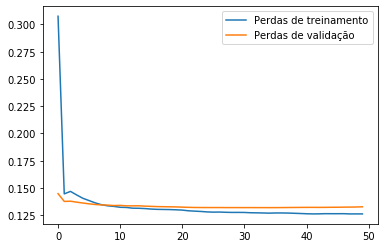

In [12]:
# plot resultado
pyplot.plot(resultado.history['loss'], label='Perdas de treinamento')
pyplot.plot(resultado.history['val_loss'], label='Perdas de validação')
pyplot.legend()
pyplot.show()

In [13]:
prev_real, labels_real = get_predict(teste_X, teste_y, normalizado)

mrse, mabe = get_mrse_mabe(labels_real, prev_real)
utheil = get_utheil(labels_real, prev_real)

print('Teste MRSE: %.3f' % mrse)
print('Teste MABE: %.3f' % mabe)
print('Teste UTHEIL: %.3f' % utheil)

Teste MRSE: 2.243
Teste MABE: 1.579
Teste UTHEIL: 0.143


In [14]:
mrse_str = str(mrse).replace(".", ",")
mabe_str = str(mabe).replace(".", ",")

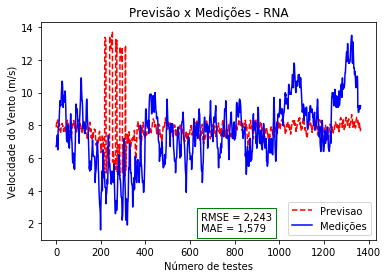

In [16]:
pyplot.plot(prev_real, '--', label='Previsao', color='red')
pyplot.plot(labels_real, label = 'Medições', color = 'blue')
pyplot.legend()
pyplot.title("Previsão x Medições - RNA")
pyplot.ylabel("Velocidade do Vento (m/s)")
pyplot.xlabel("Número de testes")
pyplot.text(650, 1.5, 'RMSE = ' + mrse_str + '\nMAE = ' + mabe_str, bbox=dict(fc='white', ec='green'))

path_save = 'PrevisaoRNA'
pyplot.savefig(path_save, dpi=600, format='pdf')
pyplot.show()